## About the dataset
This dataset is adapted from the Wine Data Set from https://archive.ics.uci.edu/ml/datasets/wine by removing the information about the types of wine for unsupervised learning.

The following descriptions are adapted from the UCI webpage:

These data are the results of a chemical analysis of wines grown in the same region in Italy but derived from three different cultivars. The analysis determined the quantities of 13 constituents found in each of the three types of wines.

The attributes are:

- Alcohol
- Malic acid
- Ash
- Alcalinity of ash
- Magnesium
- Total phenols
- Flavanoids
- Nonflavanoid phenols
- Proanthocyanins
- Color intensity
- Hue
- OD280/OD315 of diluted wines
- Proline

178 rows → each row represent one wine entry

13 columns → each column represents wine’s attribute


 Alcohol
 Malic acid
 Ash
 Alcalinity of ash
 Magnesium
 Total phenols
 Flavanoids
 Nonflavanoid phenols
 Proanthocyanins
 Color intensity
 Hue
 OD280/OD315 of diluted wines
 Proline



## Problematic

- Perform K-means with and without PCA
- Compare the results
- How to validate number of clusters with/without knowing about the correct answer

In [35]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.options.display.float_format = "{:.2f}".format

import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import GridSearchCV

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import adjusted_rand_score, silhouette_score, normalized_mutual_info_score, fowlkes_mallows_score
from sklearn.decomposition import PCA
import time
from kneed import KneeLocator

In [2]:
# Importing the dataset
df = pd.read_csv('wine-clustering.csv')


In [5]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Alcohol               178 non-null    float64
 1   Malic_Acid            178 non-null    float64
 2   Ash                   178 non-null    float64
 3   Ash_Alcanity          178 non-null    float64
 4   Magnesium             178 non-null    int64  
 5   Total_Phenols         178 non-null    float64
 6   Flavanoids            178 non-null    float64
 7   Nonflavanoid_Phenols  178 non-null    float64
 8   Proanthocyanins       178 non-null    float64
 9   Color_Intensity       178 non-null    float64
 10  Hue                   178 non-null    float64
 11  OD280                 178 non-null    float64
 12  Proline               178 non-null    int64  
dtypes: float64(11), int64(2)
memory usage: 18.2 KB


In [3]:
# describe the df
df.describe()


,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline
count,178.00,178.00,178.00,178.00,178.00,178.00,178.00,178.00,178.00,178.00,178.00,178.00,178.00
mean,13.00,2.34,2.37,19.49,99.74,2.30,2.03,0.36,1.59,5.06,0.96,2.61,746.89
std,0.81,1.12,0.27,3.34,14.28,0.63,1.00,0.12,0.57,2.32,0.23,0.71,314.91
min,11.03,0.74,1.36,10.60,70.00,0.98,0.34,0.13,0.41,1.28,0.48,1.27,278.00
25%,12.36,1.60,2.21,17.20,88.00,1.74,1.21,0.27,1.25,3.22,0.78,1.94,500.50
50%,13.05,1.87,2.36,19.50,98.00,2.35,2.13,0.34,1.56,4.69,0.96,2.78,673.50
75%,13.68,3.08,2.56,21.50,107.00,2.80,2.88,0.44,1.95,6.20,1.12,3.17,985.00
max,14.83,5.80,3.23,30.00,162.00,3.88,5.08,0.66,3.58,13.00,1.71,4.00,1680.00


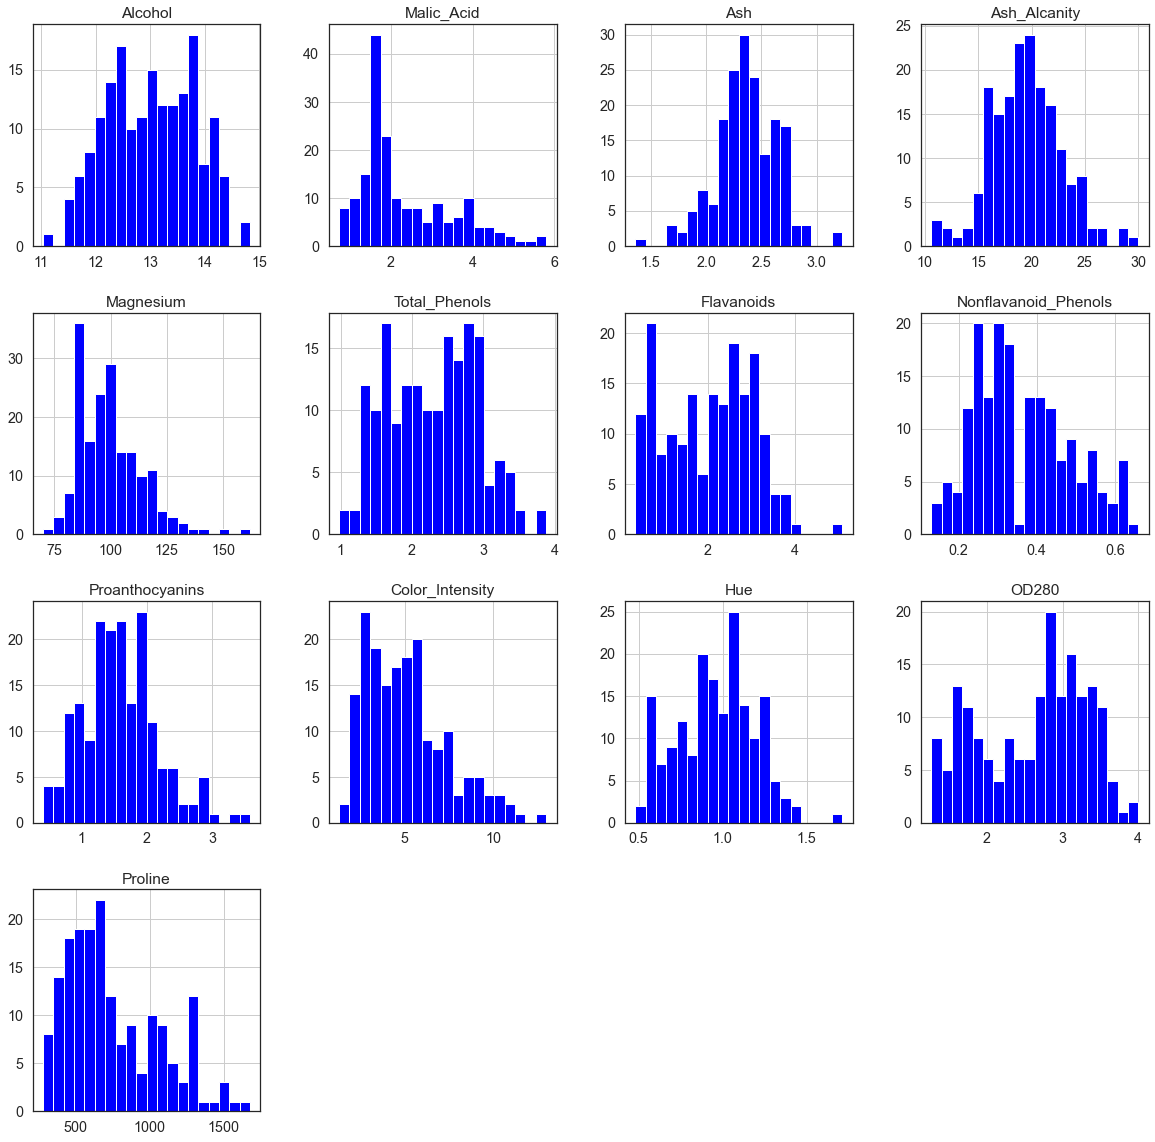

In [4]:
#plot distribution of each feature in seaborn with 4 plots in a row
sns.set(style='white',font_scale=1.3, rc={'figure.figsize':(20,20)})
ax=df.hist(bins=20,color='blue' )



In [5]:
df_scaled = pd.DataFrame()

In [6]:
# scale the data

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)
df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = df.columns


Although KMeans is a useful tool, it struggles with data that has larger dimensions. Due to the Curse of Dimensionality, the distances between various data points tend to become closer together as the dimensions rise. This is a major issue, especially when working with algorithms like KMeans, which employ distance-based metrics to discover comparable points for clustering. 
We can either reduce the number of features by:

a) By dropping features that are very similar to each other and keeping just one out of the two.

b) By combining features that represent more sensible information when considered together.

and if you cannot afford to do either of the two or even after applying them, the dimensions are a mess we then can

c) Use any of the several available dimensionality reduction techniques.




## Apply PCA


In [7]:
pca_2 = PCA(0.7)
pca_2_result = pca_2.fit_transform(df_scaled)
print('Explained variation per principal component: {}'.format(pca_2.explained_variance_ratio_))

# >> Explained variation per principal component: [0.36198848 0.1920749 ]

print('Cumulative variance explained by 4 principal components: {:.2%}'.format(np.sum(pca_2.explained_variance_ratio_)))

Explained variation per principal component: [0.36198848 0.1920749  0.11123631 0.0706903 ]
Cumulative variance explained by 4 principal components: 73.60%


In [8]:
# Results from pca.components_
dataset_pca = pd.DataFrame(abs(pca_2.components_), columns=df_scaled.columns, index=['PC_1', 'PC_2','PC3','PC4'])
print('\n\n', dataset_pca)



       Alcohol  Malic_Acid  Ash  Ash_Alcanity  Magnesium  Total_Phenols  \
PC_1     0.14        0.25 0.00          0.24       0.14           0.39   
PC_2     0.48        0.22 0.32          0.01       0.30           0.07   
PC3      0.21        0.09 0.63          0.61       0.13           0.15   
PC4      0.02        0.54 0.21          0.06       0.35           0.20   

      Flavanoids  Nonflavanoid_Phenols  Proanthocyanins  Color_Intensity  Hue  \
PC_1        0.42                  0.30             0.31             0.09 0.30   
PC_2        0.00                  0.03             0.04             0.53 0.28   
PC3         0.15                  0.17             0.15             0.14 0.09   
PC4         0.15                  0.20             0.40             0.07 0.43   

      OD280  Proline  
PC_1   0.38     0.29  
PC_2   0.16     0.36  
PC3    0.17     0.13  
PC4    0.18     0.23  


In [9]:
print("\n*************** Most important features *************************")
print('As per PC 1:\n', (dataset_pca[dataset_pca > 0.3].iloc[0]).dropna())   
print('\n\nAs per PC 2:\n', (dataset_pca[dataset_pca > 0.3].iloc[1]).dropna())
print('\n\nAs per PC 3:\n', (dataset_pca[dataset_pca > 0.3].iloc[2]).dropna())
print('\n\nAs per PC 4:\n', (dataset_pca[dataset_pca > 0.3].iloc[3]).dropna())
print("\n******************************************************************")



*************** Most important features *************************
As per PC 1:
 Total_Phenols     0.39
Flavanoids        0.42
Proanthocyanins   0.31
OD280             0.38
Name: PC_1, dtype: float64


As per PC 2:
 Alcohol           0.48
Ash               0.32
Color_Intensity   0.53
Proline           0.36
Name: PC_2, dtype: float64


As per PC 3:
 Ash            0.63
Ash_Alcanity   0.61
Name: PC3, dtype: float64


As per PC 4:
 Malic_Acid        0.54
Magnesium         0.35
Proanthocyanins   0.40
Hue               0.43
Name: PC4, dtype: float64

******************************************************************


In [10]:

#plot elbow to determine number of ks
kmeans_kwargs = {"n_init": 10, "max_iter": 300, "random_state": 42, "init":'k-means++'}

In [11]:
# #We fit K means using the transformed data from the PCA.
# WCSS = []
# for i in range(1,21):
#     kmeans_pca = KMeans (n_clusters=i, init="k-means++", random_state = 42)
#     kmeans_pca.fit(pca_2_result)
#     WCSS.append ( kmeans_pca.inertia_)

In [12]:
# A list holds the SSE values for each k
sse = []
for k in range(1, 11):
  kmeans = KMeans(n_clusters = k, **kmeans_kwargs)
  kmeans.fit(pca_2_result)
  sse.append(kmeans.inertia_)

C:\Users\Administrator\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:882: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  f"KMeans is known to have a memory leak on Windows "


## Optimal number of clusters
In addition to the curse of dimensionality problem, KMeans also has the difficulty that we must explicitly tell the KMeans model how many clusters we want our data to be divided into. Since this hit-and-trial process might be difficult, we are employing the silhouette score technique. In this section, you provide a list of likely candidates and the metrics. The silhouette score function applies the KMeans model to our data while taking one variable (number of clusters) into account at a time to determine a score.

In [13]:
#to identify the elbow point programmatically
knee_locator = KneeLocator(
      range(1, 11), sse, curve="convex", direction="decreasing")


In [14]:
knee_locator.elbow

3

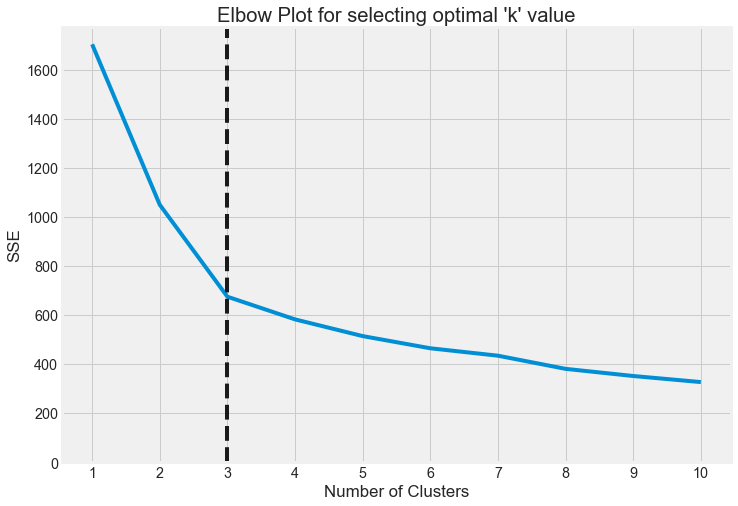

In [15]:
plt.figure(figsize=(12, 8))
plt.style.use("fivethirtyeight")

plt.plot(range(1, 11), sse)

plt.xticks(range(1, 11))
plt.ylim(ymin=0)

plt.axvline(x = knee_locator.elbow, color = 'k', linestyle='--')

plt.title("Elbow Plot for selecting optimal 'k' value")
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")

plt.show()

In [16]:
# A list holds the silhouette coefficients for each k
silhouette_coefficients = []

# Notice you start at 2 clusters for silhouette coefficient
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(pca_2_result)
    score = silhouette_score(pca_2_result, kmeans.labels_)
    silhouette_coefficients.append(score)

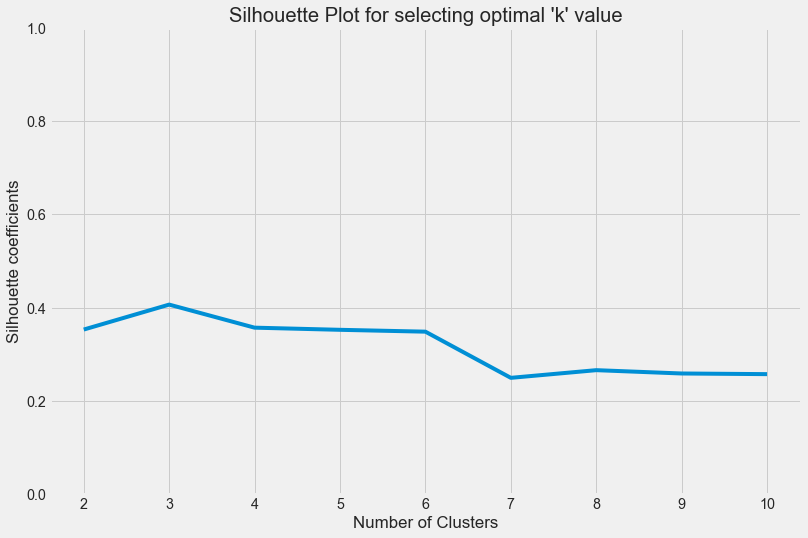

In [17]:
plt.figure(figsize=(12, 8))
plt.style.use("fivethirtyeight")

plt.plot(range(2, 11), silhouette_coefficients)

plt.xticks(range(2, 11))
plt.ylim([0,1])

plt.title("Silhouette Plot for selecting optimal 'k' value")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette coefficients")

plt.show()

In [18]:
print("The highest Silhouette coefficient score is {} for a value of k = 3".format((max(silhouette_coefficients))))


The highest Silhouette coefficient score is 0.40659691089486594 for a value of k = 3


In [19]:

# we select number of clusters to be 3 after applying elbow and silhouette method
kmeans_pca = KMeans (n_clusters=3,init='k-means++',random_state=42)

#fit data
kmeans_pca.fit(pca_2_result)



KMeans(n_clusters=3, random_state=42)

In [20]:
# create a new data from original features and add pca scores and assigned clusters
df_segm_pca_means = pd.concat([df.reset_index(drop=True),pd.DataFrame(pca_2_result)],axis=1)
df_segm_pca_means.columns.values[-4:] = ['component 1','component 2','component 3','component 4']
df_segm_pca_means["Segment K-means PCA"] = kmeans_pca.labels_
# Get the cluster centroids and labels
centroids = kmeans.cluster_centers_
centroid_labels = kmeans.labels_

In [21]:
df_segm_pca_means.head()

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline,component 1,component 2,component 3,component 4,Segment K-means PCA
0,14.23,1.71,2.43,15.60,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065,3.32,-1.44,-0.17,-0.22,1
1,13.20,1.78,2.14,11.20,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,2.21,0.33,-2.03,-0.29,1
2,13.16,2.36,2.67,18.60,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,2.52,-1.03,0.98,0.72,1
3,14.37,1.95,2.50,16.80,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480,3.76,-2.76,-0.18,0.57,1
4,13.24,2.59,2.87,21.00,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735,1.01,-0.87,2.03,-0.41,1


In [22]:
# create a new column
df_segm_pca_means["Segment"] = df_segm_pca_means["Segment K-means PCA"].map(
    {0:'first',
    1:'second',
    2:'third',
    3:'fourth'}
)

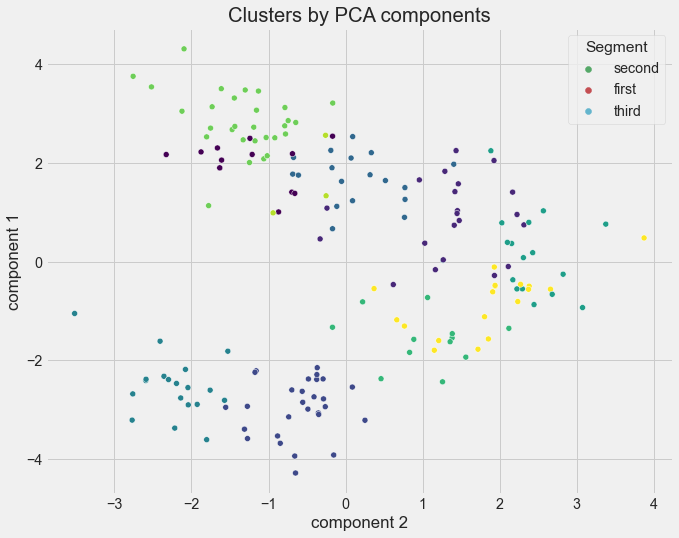

In [23]:
plt.figure(figsize=(10,8))
sns.scatterplot(x=df_segm_pca_means["component 2"],y= df_segm_pca_means["component 1"],hue=df_segm_pca_means['Segment'],palette=['g','r','c'],c=centroid_labels.astype(float), cmap="viridis")
plt.title("Clusters by PCA components")
#plt.scatter(centroids[:, 0], centroids[:, 1], c='r', marker='X', s=180)

plt.show()

# K-means without PCA

In [49]:

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)
df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = df.columns

In [50]:

# we select number of clusters to be 3 after applying elbow and silhouette method
kmeans = KMeans (n_clusters=3,init='k-means++',random_state=42)

#fit data
kmeans.fit(df_scaled)
# Get the cluster centroids and labels
centroids = kmeans.cluster_centers_
centroid_labels = kmeans.labels_


In [51]:
# A list holds the silhouette coefficients for each k
silhouette_coefficients = []

# Notice you start at 2 clusters for silhouette coefficient
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(df_scaled)
    score = silhouette_score(df_scaled, kmeans.labels_)
    silhouette_coefficients.append(score)

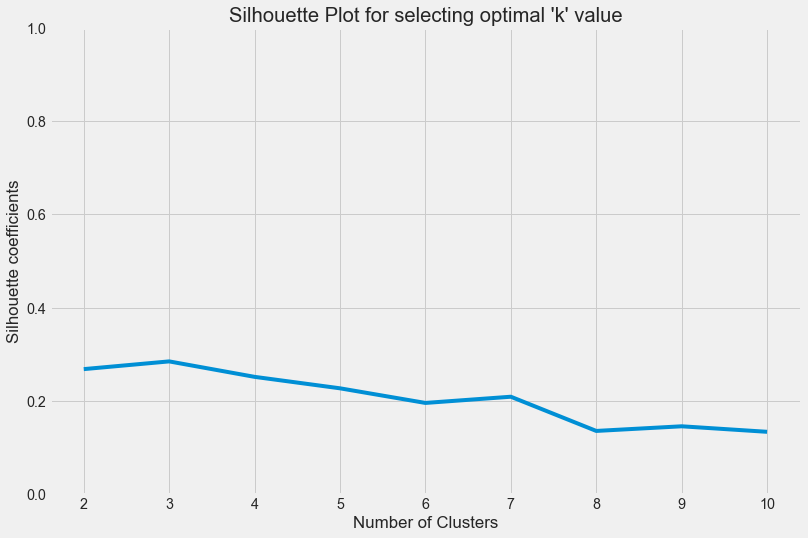

In [52]:
plt.figure(figsize=(12, 8))
plt.style.use("fivethirtyeight")

plt.plot(range(2, 11), silhouette_coefficients)

plt.xticks(range(2, 11))
plt.ylim([0,1])

plt.title("Silhouette Plot for selecting optimal 'k' value")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette coefficients")

plt.show()

In [53]:
#print the max silhouette score

print("The highest Silhouette coefficient score is {} for a value of k = 3".format((max(silhouette_coefficients))))

The highest Silhouette coefficient score is 0.2848589191898987 for a value of k = 3


In [54]:
#We will use scalling of our data.
sc = StandardScaler()
df2 = sc.fit_transform(df)

In [55]:
# create a new column
df_scaled["Segment K-means"] = kmeans_pca.labels_


In [56]:
# map the values of labels
df_scaled["Segment"] = df_scaled["Segment K-means"].map(
                                                        {0:'first',
                                                        1:'second',
                                                        2:'third',
                                                        3:'fourth'}
                                                        )
                                                    

In [ ]:
# scatter plot wwithout pca colored by segments
plt.figure(figsize=(10,8))
sns.scatterplot(x=df_scaled["Annual Income (k$)"],y= df_scaled["Spending Score (1-100)"],hue=df_scaled['Segment'],palette=['g','r','c'],c=centroid_labels.astype(float), cmap="viridis")
plt.title("Clusters by Annual Income and Spending Score")


# Comparison

In [36]:
# import labelled df

df_label = pd.read_csv("wine_label.csv")

In [37]:
# view the data
df_label['Cultivars'].unique() # cultivars is the label

array([1, 2, 3], dtype=int64)

In [38]:
# drop unnamed column:0
df_label.drop('Unnamed: 0',axis=1,inplace=True)

In [42]:
true_labels= df_label["Cultivars"]

In [40]:
# with PCA
# scale the data

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)
df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = df.columns


In [43]:
# Run k-means without PCA
start = time.time()
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(df_scaled)
labels = kmeans.predict(df_scaled)
end = time.time()
print("k-means without PCA")
print("Adjusted Rand index:", adjusted_rand_score(true_labels, labels))
print("Normalized Mutual Information:", normalized_mutual_info_score(true_labels, labels))
print("Fowlkes-Mallows index:", fowlkes_mallows_score(true_labels, labels))
print("Silhouette score:", silhouette_score(df_scaled, labels))
print("Time taken:",end - start)

# Run k-means with PCA
start = time.time()
pca = PCA(n_components=5)
data_pca = pca.fit_transform(df_scaled)
kmeans_pca = KMeans(n_clusters=3, random_state=42)
kmeans_pca.fit(data_pca)
labels_pca = kmeans_pca.predict(data_pca)
end = time.time()
print("k-means with PCA")
print("Adjusted Rand index:", adjusted_rand_score(true_labels, labels_pca))
print("Normalized Mutual Information:", normalized_mutual_info_score(true_labels, labels_pca))
print("Fowlkes-Mallows index:", fowlkes_mallows_score(true_labels, labels_pca))
print("Silhouette score:", silhouette_score(data_pca, labels_pca))
print("Time taken:",end - start)

k-means without PCA
Adjusted Rand index: 0.8974949815093207
Normalized Mutual Information: 0.875893534122307
Fowlkes-Mallows index: 0.9319080608075307
Silhouette score: 0.2848589191898987
Time taken: 0.1510014533996582
k-means with PCA
Adjusted Rand index: 0.8974949815093207
Normalized Mutual Information: 0.875893534122307
Fowlkes-Mallows index: 0.9319080608075307
Silhouette score: 0.36907631946992286
Time taken: 0.033998966217041016


In [45]:
# print the results above as a table
from tabulate import tabulate

table = [["k-means without PCA", adjusted_rand_score(true_labels, labels), normalized_mutual_info_score(true_labels, labels), fowlkes_mallows_score(true_labels, labels), silhouette_score(df_scaled, labels), end - start],    

            ["k-means with PCA", adjusted_rand_score(true_labels, labels_pca), normalized_mutual_info_score(true_labels, labels_pca), fowlkes_mallows_score(true_labels, labels_pca), silhouette_score(data_pca, labels_pca), end - start]]

print(tabulate(table, headers=["Algorithm", "Adjusted Rand Index", "Normalized Mutual Information", "Fowlkes-Mallows Index", "Silhouette Score", "Time Taken"])) 




Algorithm              Adjusted Rand Index    Normalized Mutual Information    Fowlkes-Mallows Index    Silhouette Score    Time Taken
-------------------  ---------------------  -------------------------------  -----------------------  ------------------  ------------
k-means without PCA               0.897495                         0.875894                 0.931908            0.284859      0.033999
k-means with PCA                  0.897495                         0.875894                 0.931908            0.369076      0.033999


In [ ]:
#print in latex format
print(tabulate(table, headers=["Algorithm", "Adjusted Rand Index", "Normalized Mutual Information", "Fowlkes-Mallows Index", "Silhouette Score", "Time Taken"], tablefmt="latex"))
                

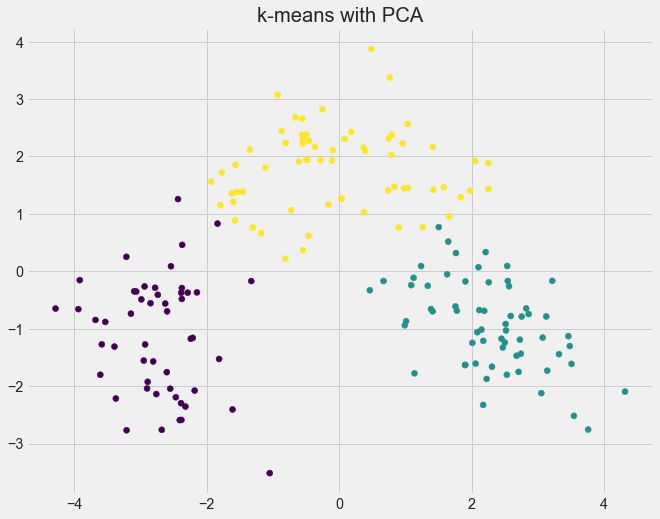

In [47]:
plt.figure(figsize=(10,8))
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=labels_pca, cmap="viridis")
plt.title("k-means with PCA")
plt.show()

In [ ]:
# plot the results 
plt.figure(figsize=(10,8))

plt.scatter(data_pca[:, 0], data_pca[:, 1], c=labels_pca, cmap="viridis")
